This file contains python code to 
get the convergence curve for alpha

In [13]:
import sys
sys.path.append("../../mypkg")

In [14]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from easydict import EasyDict as edict
from tqdm import trange, tqdm
from pprint import pprint
import itertools
from scipy.stats import chi2


In [15]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT, MIDRES_ROOT
from hdf_utils.data_gen import gen_simu_sinica_dataset
from hdf_utils.SIS import SIS_GLIM
from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse, cholesky_inv
from utils.functions import logit_fn
from utils.misc import save_pkl, load_pkl
from splines import obt_bsp_obasis_Rfn, obt_bsp_basis_Rfn_wrapper
from projection import euclidean_proj_l1ball
from optimization.opt import HDFOpt
from hdf_utils.fns_sinica import  fourier_basis_fn

from joblib import Parallel, delayed

In [17]:
plt.style.use(FIG_ROOT/"base.mplstyle")
torch.set_default_tensor_type(torch.DoubleTensor)

# Get settings

In [18]:
from easydict import EasyDict as edict
from hdf_utils.fns_sinica import coef_fn, fourier_basis_fn
from copy import deepcopy
from scenarios.base_params import get_base_params

base_params = get_base_params("linear") 
base_params.data_gen_params = edict()
base_params.data_gen_params.d = 200 # num of ROIs
base_params.data_gen_params.q = 3 # num of other covariates
base_params.data_gen_params.npts = 100 # num of pts to evaluate X(s)
base_params.data_gen_params.types_ = ["int", "c", 2]
base_params.data_gen_params.gt_alp = np.array([5, -1, 2]) 
base_params.data_gen_params.data_params={"sigma2":0.5, "srho":0.3, "basis_type":"bsp"}
base_params.data_gen_params.data_type = base_params.model_type
base_params.can_Ns = [4, 6, 8, 10, 12, 14]
base_params.SIS_params = edict({"SIS_pen": 0.02, "SIS_basis_N":8, "SIS_ws":"simpson"})
base_params.opt_params.beta = 10 
base_params.can_lams = [0.60,  0.80,  1,  1.2, 1.4, 1.6, 2.0, 4.0]

def _get_gt_beta_wrapper(d, fct=2):
    def _get_gt_beta(cs):
        x = np.linspace(0, 1, 100)
        fourier_basis = fourier_basis_fn(x)
        fourier_basis_coefs = ([cs[0]*coef_fn(0.2), cs[1]*coef_fn(0.2), cs[2]*coef_fn(0.2)] + 
                                     [np.zeros(50)] * (d-3-1) +
                                     [coef_fn(0.2)]
                                     )
        fourier_basis_coefs = np.array(fourier_basis_coefs).T 
        gt_beta = fourier_basis @ fourier_basis_coefs * fct
        return gt_beta
    return _get_gt_beta



setting = edict(deepcopy(base_params))
add_params = edict({})
add_params.data_gen_params = edict(deepcopy(base_params.data_gen_params))
add_params.data_gen_params.ns = [100, 300, 900, 2700, 8100]
add_params.data_gen_params.cs = [0, 0, 0]
add_params.data_gen_params.npts = 100 # num of pts to evaluate X(s)
add_params.data_gen_params.data_params["err_dist"] = "normal"
beta_fn = _get_gt_beta_wrapper(add_params.data_gen_params.d, 
                                                          fct=2)
add_params.data_gen_params.gt_beta = beta_fn(add_params.data_gen_params.cs)

add_params.setting = "alpcov"
add_params.sel_idx =  np.arange(0, add_params.data_gen_params.d)
add_params.SIS_ratio = 0.2
setting.update(add_params)

# Params

In [19]:
np.random.seed(0)

data_gen_params = setting.data_gen_params
x = np.linspace(0, 1, data_gen_params.npts)


num_rep = 200
save_dir = RES_ROOT/f"alp_test"
if not save_dir.exists():
    save_dir.mkdir()

# Simu

## Check data gen fn

In [22]:
data = gen_simu_sinica_dataset(
    n=data_gen_params.ns[0], 
    d=data_gen_params.d, 
    q=data_gen_params.q, 
    types_=data_gen_params.types_, 
    gt_alp=data_gen_params.gt_alp, 
    gt_beta=data_gen_params.gt_beta, 
    x=x,
    data_type=data_gen_params.data_type,
    data_params=data_gen_params.data_params, 
    seed=1, 
    verbose=2);

## SIS check (just for check)

In [11]:
def _SIS_fn(seed, SIS_ratio, N, SIS_pen, setting):
    torch.set_default_dtype(torch.double)
    np.random.seed(seed)
    torch.manual_seed(seed)
        
    data_gen_params = edict(setting.data_gen_params.copy())
    basis_mat = torch.tensor(obt_bsp(np.linspace(0, 1, data_gen_params.npts), N, 4)).to(torch.get_default_dtype())
    cur_data = gen_simu_sinica_dataset(n=data_gen_params.ns[2], 
                                   d=data_gen_params.d, 
                                   q=data_gen_params.q, 
                                   types_=data_gen_params.types_, 
                                   gt_alp=data_gen_params.gt_alp, 
                                   gt_beta=data_gen_params.gt_beta, 
                                   x=x, 
                                   data_type=data_gen_params.data_type,
                                   data_params=data_gen_params.data_params, 
                                   seed=seed, 
                                   verbose=2);
    
    keep_idxs, _  = SIS_GLIM(Y=cur_data.Y, X=cur_data.X, Z=cur_data.Z, ws=setting.SIS_params.SIS_ws,
                             basis_mat=basis_mat, keep_ratio=SIS_ratio, 
                             model_type=setting.model_type, SIS_pen=SIS_pen, sel_idx=setting.sel_idx)
    M_idxs = np.delete(np.arange(data_gen_params.d), setting.sel_idx)
    keep_idxs = np.sort(np.concatenate([M_idxs, keep_idxs]))
    return keep_idxs

In [20]:
obt_bsp = obt_bsp_obasis_Rfn
num_rep = 100
with Parallel(n_jobs=30) as parallel:
    keep_idxss = parallel(delayed(_SIS_fn)(seed, 0.05, N=8, SIS_pen=0.02, setting=setting) for seed in 
                          tqdm(range(0, num_rep), total=num_rep))

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.61it/s]


Text(0.5, 1.0, '[0.06 0.04 0.06 0.02 0.06 0.07 0.06 0.04 1.  ]')

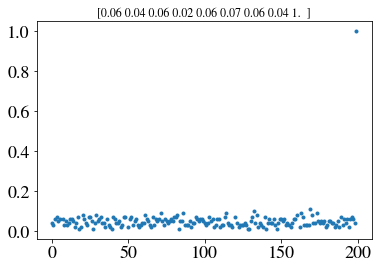

In [21]:
vs, cts = np.unique(np.concatenate(keep_idxss), return_counts=1);
cts = cts[np.argsort(vs)]/len(keep_idxss)
vs = np.sort(vs);
plt.plot(vs, cts, ".")
plt.title(f"{cts[vs > 190]}")

## Simulation

In [23]:
def _run_fn(seed, n, lam, N, setting, is_save=False, is_cv=False, verbose=2):
    """Now (on Aug 25, 2023), if we keep seed the same, the cur_data is the same. 
       If you want to make any changes, make sure this. 
    """
    torch.set_default_dtype(torch.double)
    np.random.seed(seed)
    torch.manual_seed(seed)
        
    _setting = edict(setting.copy())
    _setting.seed = seed
    _setting.lam = lam
    _setting.N = N
    
    data_gen_params = setting.data_gen_params
    x = np.linspace(0, 1, data_gen_params.npts)
    
    f_name = f"seed_{seed:.0f}-lam_{lam*1000:.0f}-N_{N:.0f}_fit.pkl"
    
    
    if not (save_dir/f_name).exists():
        cur_data = gen_simu_sinica_dataset(n=n, 
                                   d=data_gen_params.d, 
                                   q=data_gen_params.q, 
                                   types_=data_gen_params.types_, 
                                   gt_alp=data_gen_params.gt_alp, 
                                   gt_beta=data_gen_params.gt_beta, 
                                   x=x,
                                   data_type=data_gen_params.data_type,
                                   data_params=data_gen_params.data_params, 
                                   seed=seed, 
                                   verbose=verbose);
        hdf_fit = HDFOpt(lam=_setting.lam, 
                         sel_idx=_setting.sel_idx, 
                         model_type=_setting.model_type,
                         verbose=verbose, 
                         SIS_ratio=_setting.SIS_ratio, 
                         N=_setting.N,
                         is_std_data=True, 
                         cov_types=None, 
                         inits=None,
                         model_params = _setting.model_params, 
                         SIS_params = _setting.SIS_params, 
                         opt_params = _setting.opt_params,
                         bsp_params = _setting.bsp_params, 
                         pen_params = _setting.pen_params
               );
        hdf_fit.add_data(cur_data.X, cur_data.Y, cur_data.Z)
        opt_res = hdf_fit.fit()
        
        if is_cv:
            hdf_fit.get_cv_est(_setting.num_cv_fold)
        if is_save:
            hdf_fit.save(save_dir/f_name, is_compact=False, is_force=True)
    else:
        hdf_fit = load_pkl(save_dir/f_name, verbose>=2);
        
    return hdf_fit


### single test

In [24]:
seed = 1
lam = 100
N = 4

res = _run_fn(n=100, seed=seed, lam=lam, N=N, setting=setting, is_cv=False, is_save=False, verbose=2)

2024-03-04 13:40:03,695 - optimization.opt - INFO - opt params is {'stop_cv': 0.0005, 'max_iter': 2000, 'one_step_verbose': 0, 'alpha': 0.9, 'beta': 10, 'R': 200000.0, 'linear_theta_update': 'cholesky_inv'}.
2024-03-04 13:40:03,696 - optimization.opt - INFO - SIS params is {'SIS_pen': 0.02, 'SIS_basis_N': 8, 'SIS_basis_ord': 4, 'SIS_ratio': 0.2, 'SIS_ws': 'simpson'}.
2024-03-04 13:40:03,696 - optimization.opt - INFO - model params is {'norminal_sigma2': 1, 'ws': 'simpson'}.
2024-03-04 13:40:03,697 - optimization.opt - INFO - penalty params is {'a': 3.7, 'lam': 100}.
2024-03-04 13:40:03,697 - optimization.opt - INFO - bspline params is {'basis_ord': 4, 'is_orth_basis': True, 'N': 4}.
2024-03-04 13:40:03,698 - optimization.opt - INFO - As cov_types is not provided, inferring the continuous covariates.
Main Loop:   0%|                                                                                                                                      | 0/2000 [00:00<?, ?it/s]

> /data/rajlab1/user_data/jin/MyResearch/HDF_infer/mypkg/optimization/one_step_opt.py(137)_update_theta_linearmodel()
    135                 left_mat = tmp_mat/self.model.sigma2 + self.paras.beta * self.D.T@self.D
    136                 pdb.set_trace()
--> 137                 self.linear_mat = cholesky_inv(left_mat)
    138             thetak_raw = self.linear_mat @ right_vec;
    139 



ipdb>  left_mat.shape


torch.Size([163, 163])


ipdb>  torch.svd(left_mat).S


tensor([57.2178, 55.4058, 53.0694, 52.2118, 51.3775, 47.8044, 46.0220, 45.2815,
        43.7509, 42.7666, 41.9594, 40.4098, 39.6580, 39.2003, 38.9800, 37.6679,
        36.5946, 34.9945, 34.7039, 34.0370, 33.6203, 32.8404, 32.3798, 31.3055,
        30.4223, 29.9873, 29.1361, 28.9585, 28.6499, 28.1087, 27.9160, 27.4978,
        27.1378, 25.7890, 25.1854, 24.8404, 24.6366, 24.1599, 23.9131, 23.4125,
        23.1589, 22.9629, 22.3370, 22.1382, 21.4552, 21.2015, 21.1237, 20.7163,
        19.9676, 19.7914, 19.6671, 19.4105, 18.7373, 18.5432, 18.2826, 17.8794,
        17.6677, 17.3771, 17.1284, 16.9192, 16.7981, 16.3064, 16.2359, 15.9525,
        15.8461, 15.6535, 15.3985, 15.2262, 15.0489, 14.5539, 14.5317, 14.2966,
        14.2322, 13.8541, 13.6342, 13.4466, 13.2702, 13.2582, 13.1214, 13.0767,
        12.9660, 12.7295, 12.6570, 12.5933, 12.3740, 12.2150, 12.0669, 12.0203,
        11.8055, 11.7589, 11.5589, 11.4674, 11.3755, 11.2755, 11.1043, 10.9633,
        10.9070, 10.8346, 10.7289, 10.00

ipdb>  q


Main Loop:   0%|                                                                                                                                      | 0/2000 [00:43<?, ?it/s]


BdbQuit: 

In [10]:
get_alp_cov(res)

NameError: name 'get_alp_cov' is not defined

In [32]:
res._prepare_hypotest()

### Multipe test

In [27]:
def get_ci(est_alp, cov_mat, alp_idx):
    ci_lim = 1.96*cov_mat[alp_idx, alp_idx].sqrt().item()
    ci = [est_alp[alp_idx].item()-ci_lim,  est_alp[alp_idx].item()+ci_lim]
    return ci
def get_alp_cov(hdf_fit):
    Q_mat = hdf_fit.hypo_utils.Q_mat_part
    Q_mat_inv = torch.linalg.pinv(Q_mat, hermitian=True, rtol=1e-7)
    Sig_mat = hdf_fit.hypo_utils.Sig_mat_part
    Cov_mat = Q_mat_inv @ Sig_mat @  Q_mat_inv / hdf_fit.data_params.n
    return Cov_mat[:hdf_fit.data_params.q,:hdf_fit.data_params.q];

In [31]:
seed = 6
N = 12
lam = 1.0

def _run_fn1(seed, n=100):
    res = _run_fn(seed=seed, n=n, lam=lam, N=N, setting=setting, is_cv=False, verbose=1)
    res._prepare_hypotest()
    test_res = edict()
    test_res.est_alp = res.est_alp
    test_res.cov_mat = get_alp_cov(res)
    return test_res
    
num_rep = 200
    

200

In [32]:
gt_alp = data_gen_params.gt_alp;
ns = data_gen_params.ns
ns = [100, 200, 400]

ci_lens = np.zeros((len(ns), len(gt_alp)-1))
cov_probs = np.zeros((len(ns), len(gt_alp)-1))
for n in ns:
    with Parallel(n_jobs=20) as parallel:
        ress = parallel(delayed(_run_fn1)(seed, n=n) for seed in tqdm(range(num_rep), total=num_rep, desc=f"n: {n}"))
    for alp_idx in range(1, data_gen_params.q):
        cis = np.array([get_ci(res.est_alp, res.cov_mat, alp_idx=alp_idx) for res in ress]);
        cov_prob = np.bitwise_and(cis[:, 0] < gt_alp[alp_idx], cis[:, 1] > gt_alp[alp_idx]).mean()
        ci_len = np.diff(cis, axis=1).mean()
        
        cov_probs[ns.index(n), alp_idx-1] = cov_prob
        ci_lens[ns.index(n), alp_idx-1] = ci_len


n: 100: 100%|██████████████████████████████████████████████████████████████████| 200/200 [00:11<00:00, 17.82it/s]

n: 200: 100%|██████████████████████████████████████████████████████████████████| 200/200 [00:20<00:00,  9.91it/s]

n: 400: 100%|██████████████████████████████████████████████████████████████████| 200/200 [00:40<00:00,  4.90it/s]


In [33]:
cov_probs

array([[0.81 , 0.885],
       [0.925, 0.935],
       [0.915, 0.94 ]])

1.326774923937027